# <center> Índice

# <center> 1. Introdução

# <center> 2. Objetivos
Este projeto tem como objetivos determinar a qualidade de uma cerveja baseado no que foi escrito sobre a mesma. O que para tal, surgem duas tarefas de classificação a ser implementadas: 
- Classificação Binária;
- Classificação Multi-Classe;

Para cada um dos diferentes tipos de classificação, será necessário determinar o melhor vocabulário a utilizar e ainda ter em consideração a dimensão da própria critica e da utilidade de certas da mesma.


# <center> 3. Inicialização e Verificação dos Dados Fornecidos

## Bibliotecas

In [1]:
import pickle
import sklearn
import nltk
import re
import cv2

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer

O projeto foi apresentado com os seguintes ficheiros:<br>
- "rateBeer75Ktrain.p", que apresenta 75 mil criticas para treino dos classificadores;
- "rateBeer25Ktest.p", que apresenta 25 mil criticas para teste dos classificadores;

Verifica-se que dentro destes ficheiros, as criticas são compostas por várias caracteristicas, entre elas o nome, estilo e mais importante o sabor,cheiro,a crítica e a classificação final da mesma, como se pode observar em baixo.

In [2]:
#Leitura de Dados fornecidos pelo Docente
beerTrain = pickle.load(open('Dados/rateBeer75Ktrain.p','rb'))
beerTest = pickle.load(open('Dados/rateBeer25Ktest.p','rb'))

#Exemplo de como aceder aos dados de Treino
print(type(beerTrain))
listBeerTrain = list(beerTrain.keys())
BeerTrain0 = beerTrain[listBeerTrain[0]]
print(BeerTrain0.keys(),"\n")
print(BeerTrain0)
print(BeerTrain0["overall"], type(BeerTrain0["overall"]))
print(BeerTrain0["smell"], type(BeerTrain0["smell"]))
print(BeerTrain0["taste"], type(BeerTrain0["taste"]))
print(BeerTrain0["review"])


<class 'dict'>
dict_keys(['name', 'style', 'who', 'feel', 'look', 'smell', 'taste', 'overall', 'review']) 

{'name': 'Anderson Valley Brother Davids Double', 'style': 'Abbey Dubbel', 'who': 'dmtroyer', 'feel': '3/5', 'look': '3/5', 'smell': '2/5', 'taste': '3/5', 'overall': '4/10', 'review': '22oz.  Pours dark brown with a red rim and off-white head.  Nose is mostly sweet malt with fairly noticeable alcohol depending on the temperature.  Flavor is sweet malt with raisin and banana yeast with some slight spice on the finish.  Very true to the style, but less than inspiring.'}
4/10 <class 'str'>
2/5 <class 'str'>
3/5 <class 'str'>
22oz.  Pours dark brown with a red rim and off-white head.  Nose is mostly sweet malt with fairly noticeable alcohol depending on the temperature.  Flavor is sweet malt with raisin and banana yeast with some slight spice on the finish.  Very true to the style, but less than inspiring.


# <center> 4. Desenvolvimento

### Desconstrução de Dicionários
Para uma melhor manipulação dos dados fornecidos, criou-se uma função `newDictFormat()` que transforma os dados dos dicionários fornecidos, num novo tipo de dicionário que apresenta apenas os dados necessário para a realização do projeto (review, overall, smell, e taste).<br>

Para uma facilitação do mesmo os valores string do "**overall**", "**smell**" e "**taste**" são transformados em tipo inteiro para uma melhor utilização em futuros métodos.

In [3]:

def DeconstructDict(data):
    """
    Função que transforma o dicionário de dados fornecida pelo docente num 
    novo dicionário de dados
    @param data: dicionário de dados fornecida pelo docente
    @return newDict: novo dicionário de dados
    """ 
    newDict = {'review':[],'overall':[],'smell':[],'taste':[]}
    listData = list(data.keys())
    for i in range(len(listData)):
        newDict['review'].append(data[listData[i]]['review'])
        newDict['overall'].append(int(data[listData[i]]['overall'].split('/')[0]))
        newDict['smell'].append(int(data[listData[i]]['smell'].split('/')[0]))
        newDict['taste'].append(int(data[listData[i]]['taste'].split('/')[0]))
    return newDict['review'], np.array(newDict['overall']), np.array(newDict['smell']), np.array(newDict['taste'])

Docs_train, overall_train, smell_train, taste_train = DeconstructDict(beerTrain)
Docs_test, overall_test, smell_test, taste_test = DeconstructDict(beerTest)

### Análise e Limpeza de Dados
Nesta secção, utiliza-se os dados que anteriormente foram recolhidos da desconstrução dos dicionários fornecidos e pretende-se então aplicar todas as condicionantes que permitam uma boa aprendizagem por parte do algoritmo e que futuramente serão utilizados pelos classifcadores selecionados.<br>
É de realçar que, primeiramente começou-se pelo tratamento dos valores inteiros de classifcação, tanto para a classificação binária (**Overall**) como para a classificação multi-classe(**Overall**,**Smell**,**Taste**), e a seguir será tratado as críticas das mesmas com a formação de um novo vocabulário

In [4]:
def dataBin(data):
    """
    Método que transforma um array de dados num array binário de acordo com
    os limites e ainda a remoção de críticas de cervejas com classificação 
    entre 2 e 9.
    @param data: lista de dados 
    @return data: lista de dados condicionada
    @return condition: condição de dados
    """
    limit1 = 2
    limit2 = 9
    data[data <= limit1] = 0 #Cerveja muito má 
    data[data >= limit2] = 1 #Cerveja muito boa 
    condition = (data > limit1) & (data < limit2)
    return data,condition

def drawGraphics(type, overallB, overallM, smell, taste):
    """
    Método que desenha gráficos de acordo com o tipo de dados fornecidos
    @param type: tipo de dados
    @param overallB: array de dados binários
    @param overallM: array de dados multi-classe
    @param smell: array de dados multi-classe (smell)
    @param taste: array de dados multi-classe (taste)
    """
    print("Criticas com avaliação muito boa (" + type + "): ", np.sum(overallB == 1))
    print("Criticas com avaliação muito má (" + type + "): ", np.sum(overallB == 0),'\n')
    print("Média de Avaliação Overall (" + type + "): ", np.mean(overallM),'/10')
    print("Média de Avaliação Smell (" + type + "): ", np.mean(smell),'/5')
    print("Média de Avaliação Taste (" + type + "): ", np.mean(taste),'/5')

    plt.figure(figsize=(25,6))
    plt.subplot(141)
    plt.title('Binário - Overall (' + type + ')')
    labels, counts = np.unique(overallB, return_counts=True)
    plt.bar(labels, counts, align='center')
    plt.xticks(labels,['Muito Má', 'Muito Boa'], size='large')
    plt.ylabel('Número de Críticas')
    plt.xlabel('Classificação')
    plt.subplot(142)
    plt.title('Multi-Classe - Overall (' + type + ')')
    labels, counts = np.unique(overallM, return_counts=True)
    plt.bar(labels, counts, align='center')
    plt.xticks(np.arange(1, 11))
    plt.ylabel('Número de Críticas')
    plt.xlabel('Classificação')

    plt.figure(figsize=(15,5))  
    labels, counts = np.unique(smell, return_counts=True)
    plt.subplot(121)
    plt.title('Multi-Classe - Smell (' + type + ')')
    plt.bar(labels, counts, align='center')
    plt.xticks(np.arange(0, 6))
    plt.ylabel('Número de Críticas')
    plt.xlabel('Classificação')

    labels, counts = np.unique(taste, return_counts=True)
    plt.subplot(122)
    plt.title('Multi-Classe - Taste (' + type + ')')
    plt.bar(labels, counts, align='center')
    plt.xticks(np.arange(0, 6))
    plt.xlabel('Classificação') 

#### Análise de Dados de Treino

Criticas com avaliação muito boa (train):  5052
Criticas com avaliação muito má (train):  3346 

Média de Avaliação Overall (train):  5.67136 /10
Média de Avaliação Smell (train):  3.0184 /5
Média de Avaliação Taste (train):  3.03116 /5


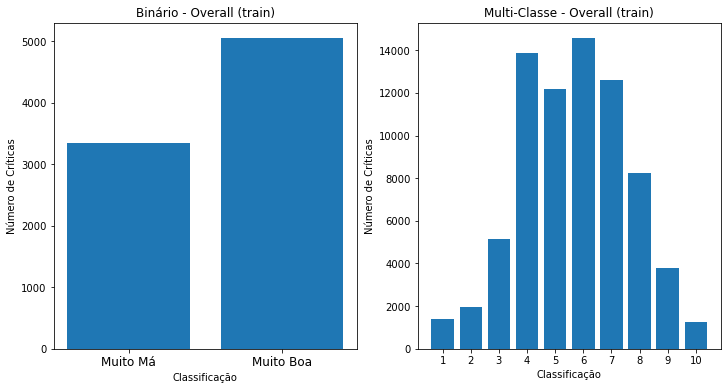

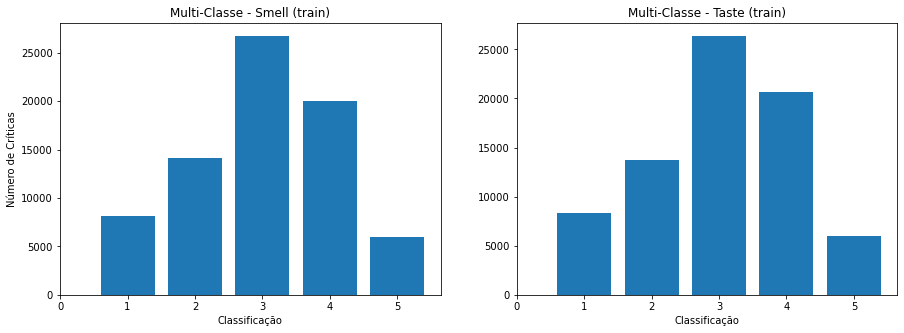

In [5]:
#Dados de Treino
overallB_train, condition = dataBin(overall_train.copy()) #Classificação binária 
overallM_train = overall_train.copy() #Classificação multi-classe
drawGraphics('train',np.delete(overallB_train,condition), overallM_train, smell_train, taste_train) 

Depois de tratamento destes dados, como podemos observar nos valores em cima apresentados, verificamos que nos dados de treino, `overallB_train`, possui-se 5052 que estão dentro da classificação **Muito boa**, e 3346 classsificações consideradas **Muito Más**. <br>
Adicionalmente para o classificador Multi-classes,`overallM_train` `smell_train` e `taste_train`, fez-se uma média para os valores de classificação e demonstrou-se também com gráficos para uma visualização mais detalhada, podendo-se concluir que os valores parecem corresponder com o indicado e pretendido por parte do enunciado.<br>

#### Análise de Dados de Teste

Criticas com avaliação muito boa (test):  1111
Criticas com avaliação muito má (test):  2429 

Média de Avaliação Overall (test):  5.047 /10
Média de Avaliação Smell (test):  2.66076 /5
Média de Avaliação Taste (test):  2.71604 /5


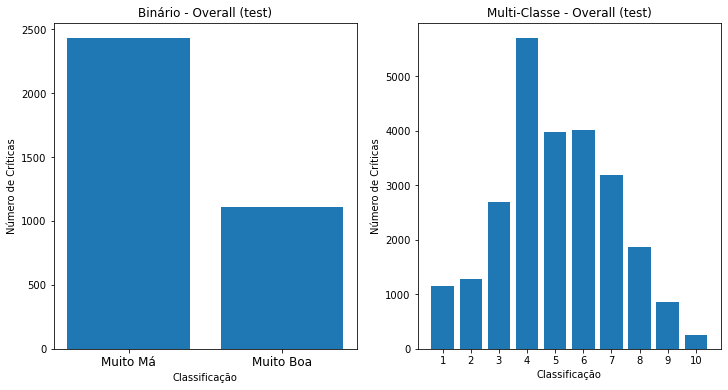

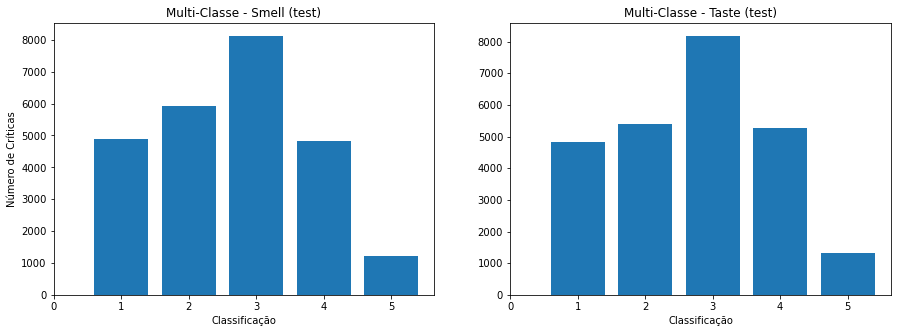

In [6]:
#Dados de Teste
overallB_test, condition  = dataBin(overall_test.copy()) #Classificação binária
overallM_test = overall_test.copy() #Classificação multi-classe 
drawGraphics('test',np.delete(overallB_test,condition), overallM_test, smell_test, taste_test)

Assim como foi feito nos dados de treino, nesta parte, é apresentado as mesmas caracteristicas de avaliação dos valores de classificação e pode-se observar que, apesar de serem menos classificações que as de treino, existe uma grande quantidade de classificações que são consideradas **Muito Más** (2429), em relação as que são consideradas **Muito Boas** (1111).<br>
Mais uma vez foram também apresentadas os valores médios das caracteristicas para a classificação multi-classe, que em comparação com os dados de treino, apresentam uma ligeira redução das mesmas. no entanto, com a visualização dos gráficos  percebe-se que continua a haver bastantes classificações iguais a 3/5, em relação ao taste e smell, e tendo um maior peso o valor 4/10 no overalal da cerveja.<br>

Tendo esta parte concluida, segue-se para o tratamento das críticas e consequentemente a criação de um vocabulário.

#### Vocabulário

Para a realização de uma aprendizagem automática com dados do tipo de texto, é necessário representar cada documento, neste caso cada crítica, como um vetor numérico. Para tal, é feito uma remoção das ordens das palavras, dando maior importância ao peso individual que estas terão para a classificação.<br>

O Resultado desta construção de vocabulário é a matriz `documento-termo` ou `corpus`. Resumidamente, para a inicialização do projeto ter-se-á que ter em conta os seguintes passos para a realização desta matriz:
- **Tokenization**, onde o documento é dividido em palavras, ou tokens;
- **Construção do Vocabulário**, onde se um vocabulário por todas as palavras presentes na matriz;
- **Codificação**, onde com base no vocabulário construido, se conta o número de ocorrências de cada palavra e ainda é feito uma vetorização dos documentos com valores proporcionais ao números de vezes da palavra do documento;<br>

No entanto, a realização deste algoritmo, poderá trazer algumas inconsistência para o *corpus*, devido à existência de artigos definidos/indefinidos, pronomes ou até mesmo conjunções de verbo que acabam por significar o mesmo e por isso tornam-se redundantes. A solução mais indicada, é a utilização de filtros para as palavras, com hiper-parâmetros que irão filtrar essas palavras que são irrelevantes para a classificação. 

##### Limpeza de Texto
Para a inicialização da construção de um vocabulário é necessário começar com a  limpeza das mesmas removendo caracteres especiais e outros elementos que não sejam relevantes para a análise dos dados, para tal, foi desenvolvido o método `textCleaning`.<br>


In [7]:
Docs_test_redux = Docs_test.copy()[:25]
print('Crítica Reduzida: \n', Docs_test_redux)

Crítica Reduzida: 
 ['Tap, Toronado during CBC week.  Good oyster flavor in this beer, but the roast and hops came through too harshly for my tastes.  Earthy and a bit mineraly.  I wish that I had nabbed a bottle because I imagine that this one had a good chance of settling down and letting those salty, earthy notes combine with more of the dark chocolate lurking beneath the roast.', 'Courtesy of Degarth. Pours dark mahogany with tan head. The aroma is big with earthiness mixed with caramel covered apples, prunes, the salty seaweedy sea shore and a fish market. The taste is a bit on the thin side but smooth too with dark roasted to burnt malts, chilli pepper notes, full up fish market counter oyster juice and earthiness. In the background is a mild sense of caramel. The fish/oyster sensation works well here with the earthy hops and roasty malts. Nice.', 'Tasted on 8/1/11 from a 12oz bottle obtained in a trade, it was a bit of a gusher.  Pours thick, oily black with a massive tan head t

In [8]:
def textCleaning(documentos):
    """
    @param documentos: lista de reviews
    @param bin: se os dados forem binários
    @return documentos: lista de reviews limpos
    """
    documentos = [doc.replace('<br />', ' ') for doc in documentos]
    documentos = [re.sub(r'[^a-zA-Z\u00C0-\u00FF]+' , ' ', doc) for doc in documentos]
    return documentos

print('Crítica Original: \n', Docs_test_redux[2])
print('Tamanho da Crítica Original: ', len(Docs_test_redux[2]))
Docs_test_redux = textCleaning(Docs_test_redux)
print('Crítica Após Limpeza: \n', Docs_test_redux[2])
print('Tamanho da Crítica Após Limpeza: ', len(Docs_test_redux[2]))


Crítica Original: 
 Tasted on 8/1/11 from a 12oz bottle obtained in a trade, it was a bit of a gusher.  Pours thick, oily black with a massive tan head that slowly recedes to some spotty lace and a thin collar.  This is the first oyster stout I have ever had where the oyster is actually discernable.  There are aromas of chocolate, roasted malt, and coffee, but the overwhelming aroma is of briny and somewhat fishy oyster.  The flavor is the same, starting off with the briny and somewhat fishy taste, and then moving on to the lightly sweet chocolate, vanilla, and a hint of coconut, and finishing with bitter dark chocolate and coffee.  The body is medium with average, but stinging carbonation and a long bitter coffee, coconut, and briny finish.
Tamanho da Crítica Original:  731
Crítica Após Limpeza: 
 Tasted on from a oz bottle obtained in a trade it was a bit of a gusher Pours thick oily black with a massive tan head that slowly recedes to some spotty lace and a thin collar This is the f

Como se consegue observar, o resultado após a limpeza, mostra que os caracteres especiais e números foram removidos diminuindo o tamanho do documento acerca de 6% do seu valor original. 

##### TfidfVectorizer
Para ajudar nesta limpeza, será também utilizado a função `TfidfVectorizer()` que é uma junção dos métodos `CountVectorizer`e `TfidfTransformer`e que tem como objetivo fazer a contagem para cada texto, do número de ocorrências de uma palavra e dar mais peso de importância a essas palavras, respetivamente. No entanto, é necessário encontrarmos os melhores parametros, minimo de repetição de palavra por documento (**min_df**) e **token_pattern** a serem utilizados antes de aplicar em todos os documentos.

In [9]:
min_df = [2, 3, 4]
token_pattern = [r'\b\w\w+\b', r'\b\w\w\w+\b', r'\b\w\w\w\w+\b']
for df in min_df:
    for token_pat in token_pattern:
        vectorizer = TfidfVectorizer(min_df=df, token_pattern=token_pat)
        vectorizer.fit(Docs_test_redux)
        print('Número de Tokens (min_df =',df,') (token_pattern =',token_pat,'):', len(vectorizer.get_feature_names_out()))
        print('Tokens (min_df =',df,') (token_pattern =',token_pat,'):''\n', vectorizer.get_feature_names_out(),'\n')

Número de Tokens (min_df = 2 ) (token_pattern = \b\w\w+\b ): 217
Tokens (min_df = 2 ) (token_pattern = \b\w\w+\b ):
 ['actually' 'aftertaste' 'ale' 'almost' 'amber' 'an' 'and' 'any' 'are'
 'aroma' 'aromas' 'around' 'as' 'at' 'average' 'back' 'bad' 'balanced'
 'be' 'beer' 'better' 'big' 'bit' 'bitter' 'bitterness' 'black' 'bodied'
 'body' 'bottle' 'brew' 'briny' 'brown' 'burnt' 'but' 'by' 'caramel'
 'carbonation' 'character' 'chocolate' 'christmas' 'citrus' 'clear'
 'cocoa' 'coffee' 'color' 'colored' 'copper' 'courtesy' 'creamy' 'crisp'
 'dark' 'decent' 'deep' 'definitely' 'degarth' 'dense' 'did' 'diminished'
 'disappointing' 'down' 'drink' 'dry' 'drying' 'earthy' 'easy' 'eda' 'end'
 'ever' 'expecting' 'faint' 'fairly' 'fine' 'finish' 'first' 'flavor'
 'flavors' 'foam' 'for' 'from' 'fruit' 'fruity' 'full' 'glass' 'going'
 'good' 'guess' 'had' 'has' 'have' 'head' 'heavy' 'herbal' 'here' 'hint'
 'hop' 'hops' 'huge' 'if' 'in' 'intense' 'is' 'isnt' 'it' 'its' 'itself'
 'ive' 'just' 'khaki' 

De acordo com os resultados anteriormente apresentados chegou-se a conclusão que os melhores parâmetros a utilizar seriam aqueles onde houvesse uma redução significativa das palavras e que não retirasse informação necessária para o algoritmo, e por isso, conclui-se o seguinte:
- **min_df** = 3
- **token_pattern** = \b\w\w\w+\b

##### Stemmer
Para finalizar a limpeza das criticas é utilizado um **stemmer**, que é o processo de transformar uma palavra na sua raiz, acabando por fazer uma junção de palavras semelhantes. Na Unidade Curricular foram leccionadas, três tipos de Stemmers:
- `Porter Stemmer`: Algoritmo que remove sufixos comuns a plavras para reduzir a sua forma raiz; 
- `Snowball Stemmer`: Uma versão melhorada de Porter Stemmer, com um suporte em várias linguas;
- `Lancaster Stemmer`: Uma versão mais agressiva que o Porter Stemmer; 

In [10]:
def DocsToVector(stemFunc,Docs):
    """
    Método que permite a criação de uma representação tfidf
    apartir da lista de strings fornecida e também do stemmer utilizado
    @param stemFunc: stemmer utilizado
    @param Docs: lista de strings
    @return tokens: lista de tokens
    @return documento_termo
    """
    Docs2 = [' '.join(stemFunc.stem(w) for w in doc.split()) for doc in Docs]
    tfidf = TfidfVectorizer(min_df=3, token_pattern=r'\b\w\w\w+\b').fit(Docs2)
    tokens = tfidf.get_feature_names_out()
    return tokens, tfidf.transform(Docs2)
  

In [11]:
stemmer1 = PorterStemmer()
stemmer2 = SnowballStemmer('english')
stemmer3 = LancasterStemmer()

#Criar Representação tfidf
tokens1 = DocsToVector(stemmer1,Docs_test_redux.copy())[0]
tokens2 = DocsToVector(stemmer2,Docs_test_redux.copy())[0]
tokens3 = DocsToVector(stemmer3,Docs_test_redux.copy())[0]

#Verificação de tokens agrupados por stemmer
print('Número de Tokens com PorterStemmer: ', len(np.unique(tokens1)))
print('Número de Tokens com SnowballStemmer: ', len(np.unique(tokens2)))
print('Número de Tokens com LancasterStemmer:', len(np.unique(tokens3)))

Número de Tokens com PorterStemmer:  121
Número de Tokens com SnowballStemmer:  121
Número de Tokens com LancasterStemmer: 117


O melhor procedimento aqui é selecionar um stemmer que nos forneça um agrupamento significativo de palavras e que ao mesmo tempo não retire "chaves" essenciais para a classificação dos textos feitos pelos criticos.<br>
Por isso, conclui-se que o melhor stemmer a utilizar será o $\textit{\textbf{SnowballStemmer}}$, pois este não apresenta um agrupamento básico como o PorterStemmer, nem um agrupamento muito rigoroso como o LancasterStemmer.

Antes de terminar a este secção de limpeza dos dados, é feito a execução dos processos anteriormente explicados nos dados fornecidos. Para facilitar estes processos foi desenvolvido um método adicional,`text2Vector()` que irá ter como retorno o vocabulário, percorrendo todos os processos até ao seu resultado final.  

In [12]:
def text2Vector(Docs):
    '''
    Método que apresenta o Corpus totalmente limpo de redundâncias
    @params Docs: lista de strings
    @return: lista de strings (corpus)
    '''
    return DocsToVector(SnowballStemmer('english'), textCleaning(Docs))

tokens_train, tfidf_Docs_train  = text2Vector(Docs_train)
tokens_test, tfidf_Docs_test, = text2Vector(Docs_test)

print('Número de Tokens no Corpus de Treino:', len(tokens_train))
print('Número de Tokens no Corpus de Teste:', len(tokens_test))

Número de Tokens no Corpus de Treino: 15179
Número de Tokens no Corpus de Teste: 9441


Foi ainda desenvolvido dois métodos auxiliares que irão ajudar para o resto do desenvolvimento do projeto, `saveFile()` e `loadFile()`. Como os nomes indicam, servirão para guardar e ler ficheiros de format pickle, este procedimento irão facilitar o uso de certos conteúdos que demoram bastante tempo a ser processados. 

In [13]:
def saveFile(name, content):
    """
    Criação de ficheiro pickle com os dados para uma melhor e mais rápida manipulação dos mesmos.
    @param name: nome do ficheiro
    @param content: conteúdo do ficheiro
    """
    with open(name+".p", 'wb') as f:
        pickle.dump(content, f)


def loadFile(name):
    """
    Leitura do ficheiro pickle com os dados, para uma melhor e mais rápida manipulação dos mesmos.
    @param name: nome do ficheiro
    @return pickle.load(f): conteúdo do ficheiro
    """
    with open(name+".p", 'rb') as f:
        return pickle.load(f)

data_train = {"tokens": tokens_train, "tfidf_Docs": tfidf_Docs_train}
data_test = {"tokens": tokens_test, "tfidf_Docs": tfidf_Docs_test}
saveFile('Dados/bin/bin_tfidf_train',data_train)
saveFile('Dados/bin/bin_tfidf_test',data_test)

## Classificação Binária



In [14]:
def dataBin_reformed(data):
    """
    Méotdo vai transformar todos os valores dos dados em binário
    e separar em dois arrays diferentes um só com positivos e outro só com negativos
    ambos os arrays terão a mesam diemnsão mas diferenciam o valor binario de acordo com
    a classificação; 1 para positivo e 0 para negativo
    """
    dataB, _ = dataBin(data)
    data_pos = []
    data_neg = []
    for i in range(len(dataB)):
        if dataB[i] == 1:
            data_pos.append(1)
            data_neg.append(0)
        elif dataB[i] == 0:
            data_pos.append(0)
            data_neg.append(1)
        else:
            data_pos.append(0)
            data_neg.append(0)
    
    return np.array(data_pos), np.array(data_neg)

### SVM 

#### Encontrar Melhores Parâmetros

In [15]:
Docs_train, overall_train,_,_ = DeconstructDict(loadFile('Dados/rateBeer75Ktrain'))
Docs_test, overall_test,_,_ = DeconstructDict(loadFile('Dados/rateBeer25Ktest'))

overallB_train_pos, overallB_train_neg = dataBin_reformed(overall_train)[0], dataBin_reformed(overall_train)[1]
overallB_test_pos, overallB_test_neg = dataBin_reformed(overall_test)[0], dataBin_reformed(overall_test)[1]

Docs_train_cleaned = textCleaning(Docs_train)
Docs_test_cleaned = textCleaning(Docs_test)

In [16]:
def SVM_bestCP_finder(overallB,Docs):
    Docs1, Docs2, y1, y2 = train_test_split(Docs, overallB, test_size=1/3, stratify=overallB)
    Docs1t, Docs1v, y1t, y1v = train_test_split(Docs1, y1, test_size=1/2, stratify=y1)

    tfidf = TfidfVectorizer(min_df=3, token_pattern=r'\b\w\w\w+\b').fit(Docs1)
    X1t, X1v = tfidf.transform(Docs1t), tfidf.transform(Docs1v)

    Cs = np.arange(1, 10, 0.5) 
    Penalty = ['l1', 'l2'] 
    tuple_CP = [(p, c) for p in Penalty for c in Cs]
    resultados_CP = []
    for p, c in tuple_CP:
        print(p, c)
        svm = LinearSVC(dual=False, penalty=p, C=c, max_iter=5000, tol=1e-2)
        scores = cross_val_score(svm, X1v, y1v, cv=5)
        resultados_CP.append(np.mean(scores))
    data = {'parametros': tuple_CP, 'scores': resultados_CP}
    return data

In [32]:
def SVM_crossValidationScore(data,type):
    scores = data['scores']
    Cs = np.arange(1, 10, 0.5) 
    intervalo = int((10-1)/0.5)
    resultados_L1 = scores[0:intervalo]
    resultados_L2 = scores[intervalo:2*intervalo]

    print('Melhor C da Penalização L1: ', Cs[np.argmax(resultados_L1)], '| Pior C da Penalização L1: ', Cs[np.argmin(resultados_L1)])
    print('Melhor C de Penalização L2: ', Cs[np.argmax(resultados_L2)], '| Pior C de Penalização L2: ', Cs[np.argmin(resultados_L2)], '\n')

    print('Acerto de Validação do Melhor C da Penalização L1:', np.max(resultados_L1))
    print('Acerto de Validação do Melhor C da Penalização L2:', np.max(resultados_L2), '\n')

    plt.figure(figsize=(10,6))
    plt.plot(Cs, resultados_L1,  '-X')
    plt.plot(Cs, resultados_L2, '-X')
    plt.title("Cross Validation Score "+type)
    plt.xlabel('Valores de C')
    plt.ylabel('Acertos de Validação')
    plt.legend(('l1', 'l2'))
    plt.grid()    

Melhor C da Penalização L1:  1.0 | Pior C da Penalização L1:  9.5
Melhor C de Penalização L2:  1.0 | Pior C de Penalização L2:  9.5 

Acerto de Validação do Melhor C da Penalização L1: 0.93208
Acerto de Validação do Melhor C da Penalização L2: 0.9326800000000001 



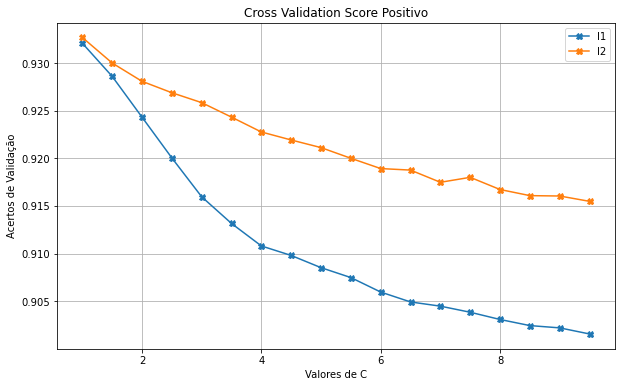

In [33]:
data = loadFile("Dados/bin/svm/parametrosLinearSVC_pos")
SVM_crossValidationScore(data, "Positivo")

Segundo os valores obtidos, e o gráfico demonstrado acima, podemos verificar que os melhores valores a utilizar para os valores positivos neste tipo de classificador são: $\textbf{C = 1}$ com uma penalização $\textbf{L1}$. Uma vez que a percentagem de acerto de Validação feito pelo L1 quando C = 1 é aproximadamente 93.20% e em L2, no mesmo ponto, é 93.16%, havendo uma ligeira diferença de 0.04% de melhoria.

Melhor C da Penalização L1:  1.0 | Pior C da Penalização L1:  9.5
Melhor C de Penalização L2:  1.0 | Pior C de Penalização L2:  9.5 

Acerto de Validação do Melhor C da Penalização L1: 0.89
Acerto de Validação do Melhor C da Penalização L2: 0.8897999999999999 



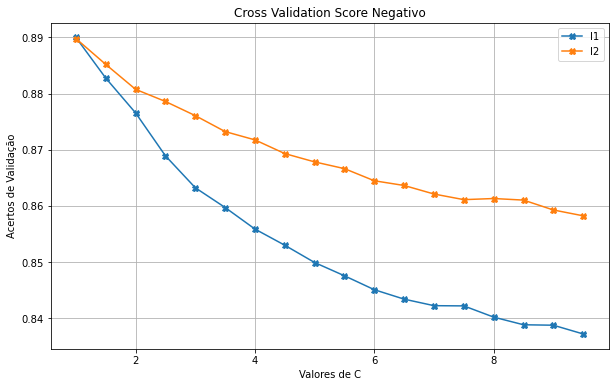

In [34]:
data = loadFile("Dados/bin/svm/parametrosLinearSVC_neg")
SVM_crossValidationScore(data,"Negativo")

Para os casos negativos, podemos observar no gráfico acima que o melhor C a utilizar é **C=1** e ainda que a sua **penalty** deve ser do tipo **L1**, pois possui um melhor resultado com 0.15% a mais que o L2. **(Acerto de validação = 88.87%)**

#### Treino do Classificador

In [19]:
tokens_train,X1 = loadFile("Dados/bin/bin_tfidf_train")["tokens"], loadFile("Dados/bin/bin_tfidf_train")["tfidf_Docs"]
tokens_test,X2 = loadFile("Dados/bin/bin_tfidf_test")["tokens"], loadFile("Dados/bin/bin_tfidf_test")["tfidf_Docs"]
print("Tokens de Treino: ", len(tokens_train),"| Tokens de Teste: ", len(tokens_test))
print("Dimensão de X1: ", X1.shape, "| Dimensão de X2: ", X2.shape)

Tokens de Treino:  15179 | Tokens de Teste:  9441
Dimensão de X1:  (75000, 15179) | Dimensão de X2:  (25000, 9441)


In [20]:
def SVM_Classifier(X,overallB_train, p, c, filename):
    svm = LinearSVC(dual=False, penalty=p, C=c, max_iter=5000, tol=1e-2).fit(X, overallB_train)
    saveFile("Dados/bin/svm/"+filename, svm)

SVM_Classifier(X2,overallB_test_pos, 'l2', 1, 'modeloLinearSVC_test_pos')
SVM_Classifier(X2,overallB_test_neg, 'l1', 1, 'modeloLinearSVC_test_neg')

In [22]:
svm_ts_pos = loadFile("Dados/bin/svm/modeloLinearSVC_test_pos")
svm_ts_neg = loadFile("Dados/bin/svm/modeloLinearSVC_test_neg")

def SVM_Results(tokens,svm,X,overallB,type, test=False):
    score = "Score: "+str(np.round(svm.score(X,overallB)*100,2))+"%"
    print("Tamanho de Vocabulário ("+type+"): ", len(tokens),"| "+ score)
    print('Número de Erros Teste: ', np.sum(overallB != svm.predict(X)))
    print("Matriz de Confusão: \n", confusion_matrix(overallB, svm.predict(X)),"\n")
        

def SVM_Vocabulary(svm):
    w = svm.coef_.squeeze()
    idx = np.argsort(w)
    voc = [tokens_test[i] for i in idx]
    print('Palavras mais relevantes para classificação negativa: ', voc[-10:])
    print('Palavras mais relevantes para classificação positiva: ', voc[10:])
    plt.figure(figsize=(10, 10))
    plt.title('Ordenação dos pesos')
    plt.barh(voc[:20], w[idx][:20])
    plt.barh(voc[-20:], w[idx][-20:])
    plt.axis('equal')
    plt.show()

In [23]:
SVM_Results(tokens_test,svm_ts_pos,X2,overallB_test_pos,"Teste Positivo",True)
SVM_Results(tokens_test,svm_ts_neg,X2,overallB_test_neg,"Teste Negativo",True)

Tamanho de Vocabulário (Teste Positivo):  9441 | Score: 97.22%
Número de Erros Teste:  694
Matriz de Confusão: 
 [[23876    13]
 [  681   430]] 

Tamanho de Vocabulário (Teste Negativo):  9441 | Score: 91.1%
Número de Erros Teste:  2224
Matriz de Confusão: 
 [[21263   197]
 [ 2027  1513]] 



Palavras mais relevantes para classificação negativa:  ['pound', 'georg', 'avail', 'effer', 'cordial', 'stone', 'firework', 'disap', 'fantast', 'silk', 'suppli', 'chart', 'gordon', 'mouthfil', 'amaz', 'intic', 'wow', 'desert', 'favourit', 'brunehaut', 'incred', 'cam', 'durhamb', 'fascin', 'ding', 'savor', 'best', 'hype', 'scrumptious', 'ponder', 'jerri', 'meal', 'teeni', 'perfect', 'conclus', 'compos', 'steal', 'favorit', 'krausenjockey', 'specif', 'wait', 'glimps', 'reward', 'outstand', 'told', 'finest', 'jame', 'tangy', 'everyon', 'fabul']
Palavras mais relevantes para classificação positiva:  ['around', 'still', 'quench', 'chalk', 'vanish', 'head', 'crazi', 'cool', 'here', 'piney', 'acquir', 'build', 'offer', 'vsk', 'stomach', 'cone', 'spruce', 'abov', 'sainsburi', 'crown', 'corn', 'annoy', 'execut', 'wheati', 'aught', 'brownish', 'characterist', 'peak', 'minti', 'concord', 'heat', 'guard', 'dunkel', 'complaint', 'pil', 'yourself', 'suggest', 'hopfenstark', 'slikwili', 'harsh', 'aro

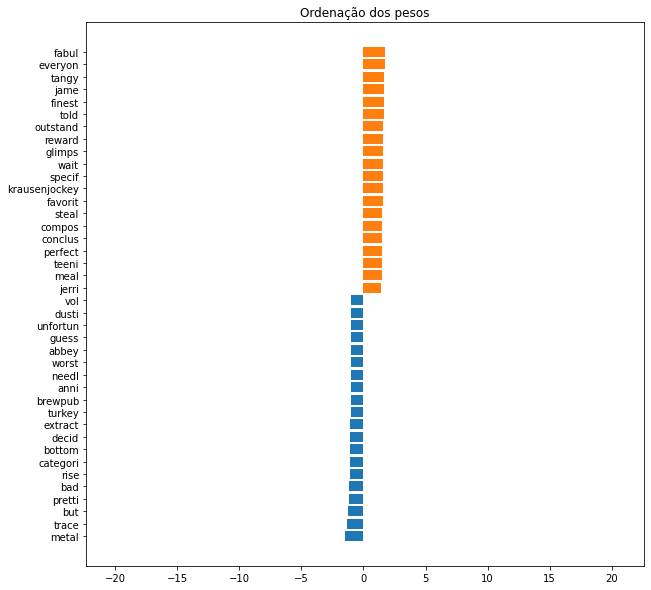

Palavras mais relevantes para classificação negativa:  ['desert', 'savor', 'rancid', 'fake', 'tourist', 'worst', 'journey', 'yorkshir', 'flavourless', 'scrumptious', 'glimps', 'gordon', 'coop', 'tiresom', 'dsagrabl', 'innocu', 'ridden', 'perman', 'rude', 'artif', 'gym', 'combo', 'teeni', 'chart', 'cleanser', 'drain', 'click', 'nasti', 'avenu', 'accident', 'extream', 'cluster', 'wast', 'astreng', 'upset', 'awful', 'krausenjockey', 'alki', 'corsendonk', 'crayon', 'yike', 'nope', 'earti', 'langu', 'laker', 'mann', 'jerri', 'intic', 'imprint', 'headach']
Palavras mais relevantes para classificação positiva:  ['mme', 'mountain', 'chambl', 'gueuz', 'wash', 'dig', 'neat', 'glaze', 'kolsch', 'interest', 'craig', 'offwhit', 'oppos', 'nice', 'unusu', 'center', 'arm', 'legend', 'but', 'mes', 'primarili', 'overshadow', 'gum', 'growler', 'disturb', 'czech', 'muddi', 'brief', 'annual', 'previous', 'maibock', 'gingerbread', 'brian', 'semblanc', 'unsweeten', 'differ', 'ocb', 'pretti', 'repres', 'sippe

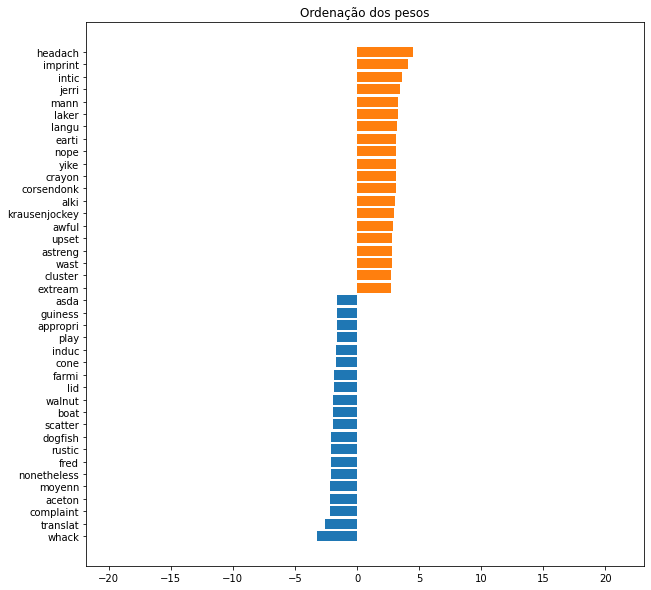

In [24]:
SVM_Vocabulary(svm_ts_pos)
SVM_Vocabulary(svm_ts_neg)

### Regressão Logistica
#### Encontrar os Melhores Valores

In [25]:
Docs_train, overall_train,_,_ = DeconstructDict(loadFile('Dados/rateBeer75Ktrain'))
Docs_test, overall_test,_,_ = DeconstructDict(loadFile('Dados/rateBeer25Ktest'))

overallB_train_pos, overallB_train_neg = dataBin_reformed(overall_train)[0], dataBin_reformed(overall_train)[1]
overallB_test_pos, overallB_test_neg = dataBin_reformed(overall_test)[0], dataBin_reformed(overall_test)[1]

Docs_train_cleaned = textCleaning(Docs_train)
Docs_test_cleaned = textCleaning(Docs_test)

In [26]:
def RL_bestCP_finder(overallB,Docs):
    Docs1, Docs2, y1, y2 = train_test_split(Docs, overallB, test_size=1/3, stratify=overallB)
    Docs1t, Docs1v, y1t, y1v = train_test_split(Docs1, y1, test_size=1/2, stratify=y1)

    tfidf = TfidfVectorizer(min_df=3, token_pattern=r'\b\w\w\w+\b').fit(Docs1)
    X1t, X1v = tfidf.transform(Docs1t), tfidf.transform(Docs1v)

    Cs = np.arange(1, 5, 0.5) 
    Penalty = ['l1', 'l2'] 
    tuple_CP = [(p, c) for p in Penalty for c in Cs]
    resultados_CP = []
    for p, c in tuple_CP:
        print(p, c)
        dl = LogisticRegression(penalty=p, C=c, random_state=42, solver='saga',max_iter=5000).fit(X1v, y1v)
        scores = cross_val_score(dl, X1v, y1v, cv=5)
        resultados_CP.append(np.mean(scores))
    data = {'parametros': tuple_CP, 'scores': resultados_CP}
    return data

In [37]:
def RL_crossValidationScore(data,type):
    scores = data['scores']
    Cs = np.arange(1, 5, 0.5) 
    intervalo = int((5-1)/0.5)
    resultados_L1 = scores[0:intervalo]
    resultados_L2 = scores[intervalo:2*intervalo]

    print('Melhor C da Penalização L1: ', Cs[np.argmax(resultados_L1)], '| Pior C da Penalização L1: ', Cs[np.argmin(resultados_L1)])
    print('Melhor C de Penalização L2: ', Cs[np.argmax(resultados_L2)], '| Pior C de Penalização L2: ', Cs[np.argmin(resultados_L2)], '\n')

    print('Acerto de Validação do Melhor C da Penalização L1:', np.max(resultados_L1))
    print('Acerto de Validação do Melhor C da Penalização L2:', np.max(resultados_L2), '\n')

    plt.figure(figsize=(10,6))
    plt.plot(Cs, resultados_L1,  '-X')
    plt.plot(Cs, resultados_L2, '-X')
    plt.title('Cross Validation Score '+type)
    plt.xlabel('Valores de C')
    plt.ylabel('Acertos de Validação')
    plt.legend(('l1', 'l2'))
    plt.grid()

Melhor C da Penalização L1:  1.0 | Pior C da Penalização L1:  4.5
Melhor C de Penalização L2:  2.0 | Pior C de Penalização L2:  4.5 

Acerto de Validação do Melhor C da Penalização L1: 0.9343600000000001
Acerto de Validação do Melhor C da Penalização L2: 0.93596 



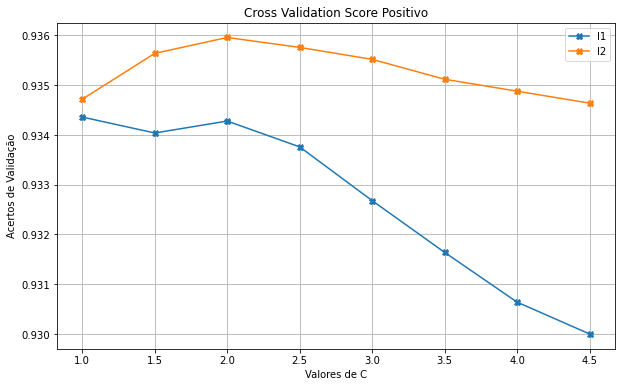

In [38]:
data = loadFile("Dados/bin/rl/parametrosRegLog_pos")
RL_crossValidationScore(data,"Positivo")

Melhor C da Penalização L1:  1.5 | Pior C da Penalização L1:  4.5
Melhor C de Penalização L2:  2.0 | Pior C de Penalização L2:  4.5 

Acerto de Validação do Melhor C da Penalização L1: 0.8918800000000001
Acerto de Validação do Melhor C da Penalização L2: 0.8924800000000002 



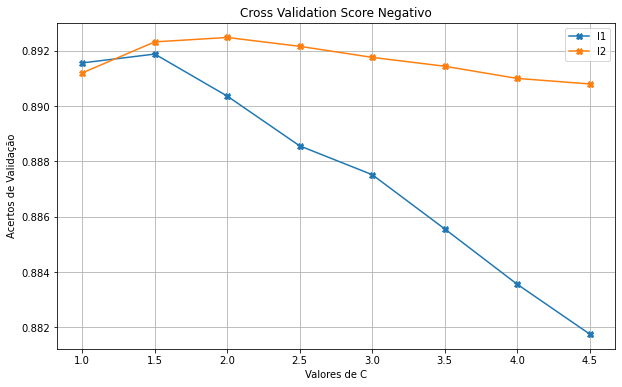

In [39]:
data = loadFile("Dados/bin/rl/parametrosRegLog_neg")
RL_crossValidationScore(data,"Negativo")

#### Treino Classificador

In [40]:
tokens_train,X1 = loadFile("Dados/bin/bin_tfidf_train")["tokens"], loadFile("Dados/bin/bin_tfidf_train")["tfidf_Docs"]
tokens_test,X2 = loadFile("Dados/bin/bin_tfidf_test")["tokens"], loadFile("Dados/bin/bin_tfidf_test")["tfidf_Docs"]
print("Tokens de Treino: ", len(tokens_train),"| Tokens de Teste: ", len(tokens_test))
print("Dimensão de X1: ", X1.shape, "| Dimensão de X2: ", X2.shape)

Tokens de Treino:  15179 | Tokens de Teste:  9441
Dimensão de X1:  (75000, 15179) | Dimensão de X2:  (25000, 9441)


In [42]:
def RL_Classifier(X,overallB_test, p, c, filename):
    dl = LogisticRegression(penalty=p, C=c, random_state=42, solver='saga',max_iter=5000).fit(X, overallB_test)
    saveFile("Dados/bin/rl/"+filename, dl)

RL_Classifier(X2,overallB_test_pos, 'l2', 2, 'modeloRL_test_pos')
RL_Classifier(X2,overallB_test_neg, 'l2', 2, 'modeloRL_test_neg')

In [50]:
rl_ts_pos = loadFile("Dados/bin/rl/modeloRL_test_pos")
rl_ts_neg = loadFile("Dados/bin/rl/modeloRL_test_neg")

def RL_Results(tokens,dl,X,overallB,type, test=False):
    score = "Score: "+str(np.round(dl.score(X,overallB)*100,2))+"%"
    print("Tamanho de Vocabulário ("+type+"): ", len(tokens),"| "+ score)
    print('Número de Erros Teste: ', np.sum(overallB != dl.predict(X)))
    print("Matriz de Confusão: \n", confusion_matrix(overallB, dl.predict(X)),"\n")
        

def RL_Vocabulary(rl):
    w = rl.coef_.squeeze()
    idx = np.argsort(w)
    voc = [tokens_test[i] for i in idx]
    print('Palavras mais relevantes para classificação negativa: ', voc[-10:])
    print('Palavras mais relevantes para classificação positiva: ', voc[10:])
    plt.figure(figsize=(10, 10))
    plt.title('Ordenação dos pesos')
    plt.barh(voc[:20], w[idx][:20])
    plt.barh(voc[-20:], w[idx][-20:])
    plt.axis('equal')
    plt.show()

In [47]:
SVM_Results(tokens_test,rl_ts_pos,X2,overallB_test_pos,"Teste Positivo",True)
SVM_Results(tokens_test,rl_ts_neg,X2,overallB_test_neg,"Teste Negativo",True)

Tamanho de Vocabulário (Teste Positivo):  9441 | Score: 96.0%
Número de Erros Teste:  1001
Matriz de Confusão: 
 [[23864    25]
 [  976   135]] 

Tamanho de Vocabulário (Teste Negativo):  9441 | Score: 89.92%
Número de Erros Teste:  2519
Matriz de Confusão: 
 [[21266   194]
 [ 2325  1215]] 



Palavras mais relevantes para classificação negativa:  ['fascin', 'choc', 'overwhelm', 'world', 'truli', 'bubblegum', 'pine', 'high', 'recommend', 'new', 'funki', 'out', 'thick', 'tart', 'deep', 'everyon', 'jame', 'delici', 'hype', 'told', 'fabul', 'you', 'avail', 'black', 'everi', 'glass', 'night', 'updat', 'balanc', 'excel', 'wish', 'wait', 'awesom', 'bourbon', 'wonder', 'stone', 'love', 'outstand', 'complex', 'incred', 'fantast', 'wow', 'great', 'amaz', 'beauti', 'favorit', 'this', 'full', 'best', 'perfect']
Palavras mais relevantes para classificação positiva:  ['mild', 'bottom', 'touch', 'label', 'brewer', 'juic', 'dusti', 'quit', 'beig', 'faint', 'dull', 'breadi', 'chocolati', 'offer', 'biscuit', 'clear', 'simpl', 'cool', 'suggest', 'unfortun', 'infect', 'though', 'salt', 'heat', 'seem', 'throat', 'nitro', 'pale', 'categori', 'odd', 'grassi', 'dimension', 'much', 'late', 'usual', 'needl', 'too', 'ester', 'characterist', 'pour', 'strang', 'bronz', 'veget', 'rise', 'orangey', 'spru

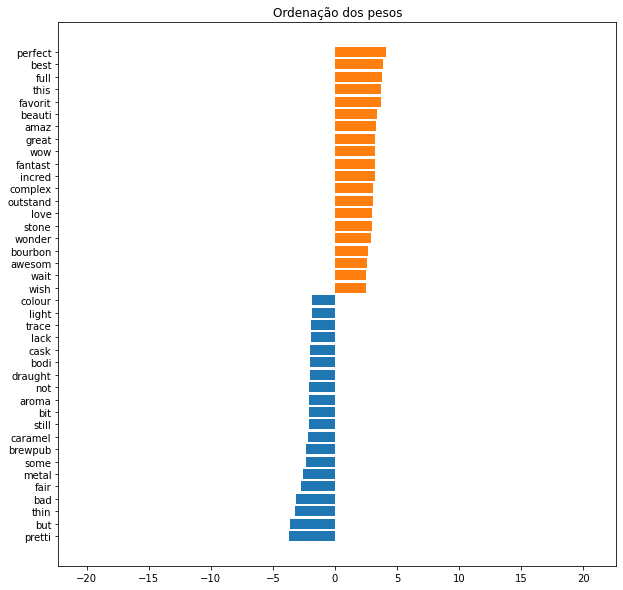

Palavras mais relevantes para classificação negativa:  ['adjunct', 'sugari', 'outstand', 'ever', 'told', 'gross', 'synthet', 'laker', 'tomato', 'liquid', 'jerri', 'popcorn', 'dms', 'horribl', 'recommend', 'lcbo', 'vagu', 'can', 'blah', 'fake', 'wow', 'weak', 'this', 'god', 'coop', 'acrid', 'below', 'amaz', 'combo', 'stone', 'stale', 'favorit', 'bore', 'bland', 'worst', 'metal', 'alki', 'veget', 'fantast', 'chemic', 'artifici', 'cardboard', 'corn', 'drain', 'incred', 'poor', 'water', 'infect', 'nasti', 'wateri']
Palavras mais relevantes para classificação positiva:  ['reddish', 'dimension', 'muddi', 'spice', 'fruiti', 'toasti', 'offwhit', 'mead', 'wood', 'point', 'walnut', 'percept', 'nitro', 'brown', 'pineappl', 'appropri', 'heat', 'floral', 'closer', 'gum', 'guess', 'boozi', 'moyen', 'sweat', 'arm', 'tan', 'draught', 'surpris', 'nov', 'cinnamon', 'bread', 'sheet', 'woodi', 'lambic', 'kolsch', 'roast', 'sipper', 'primarili', 'graviti', 'roasti', 'rubi', 'breadi', 'complaint', 'england'

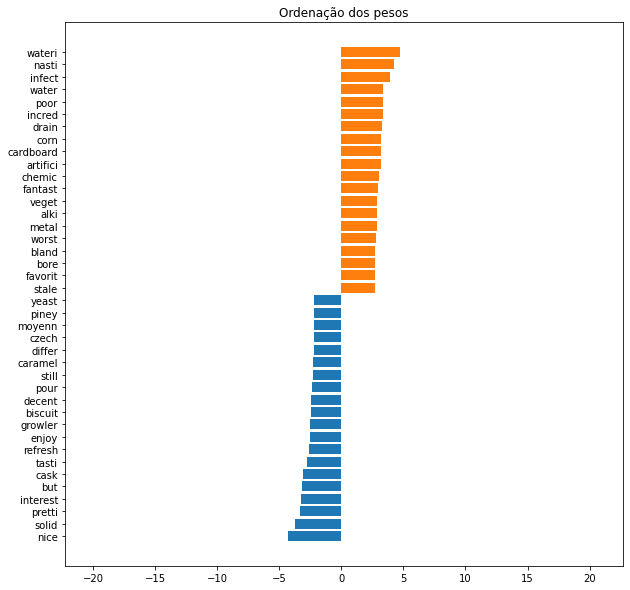

In [51]:
SVM_Vocabulary(rl_ts_pos)
SVM_Vocabulary(rl_ts_neg)

# Classificador Multi-Classe
## SVC

In [57]:
def SVM_bestCP_finder_multi(Docs,overall_train,smell_train,taste_train):
    smell_train = 2.0*smell_train
    taste_train = 2.0*taste_train
    y_med = (overall_train + smell_train + taste_train)/3.0
    return SVM_bestCP_finder(y_med,Docs)    

#### Encontrar Melhores Parâmetros

In [53]:
Docs_train, overall_train,smell_train,taste_train = DeconstructDict(loadFile('Dados/rateBeer75Ktrain'))
Docs_test, overall_test,smell_test,taste_test = DeconstructDict(loadFile('Dados/rateBeer25Ktest'))

Docs_train_cleaned = textCleaning(Docs_train)
Docs_test_cleaned = textCleaning(Docs_test)

In [58]:
data = SVM_bestCP_finder_multi(Docs_train_cleaned,overall_train,smell_train,taste_train)
saveFile("Dados/multi/svm/parametrosLinearSVC_multi", data)

Smell EX: [4. 8. 4. 6. 6. 8. 2. 6. 4. 2.]
Taste EX: [6. 6. 2. 8. 8. 8. 2. 6. 4. 4.]
Médio EX: [4.66666667 6.66666667 3.33333333 7.33333333 7.         8.
 2.33333333 5.66666667 4.33333333 3.        ]


l1 1.0


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/w4ter/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/w4ter/.local/lib/python3.10/site-packages/sklearn/base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/w4ter/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 318, in fit
    check_classification_targets(y)
  File "/home/w4ter/.local/lib/python3.10/site-packages/sklearn/utils/multiclass.py", line 221, in check_classification_targets
    raise ValueError(
ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.


## PCA